# MO Experiments

This notebook contains my tries to cluster data in 3 ways: first two uses tf-idf and countvectorizer methods to utilize names of decisions. The second tries to use word2vec, because an idea was that some actions are picked with higher probability depending on other actions that also were picked. One drawback - we have no information about time thus we cannot order decision in a sequence. Solution to that was to take a window of 25 which can represent almost any user for every game - the model just looks at all decision at once. If more data were presented and enriched by timestamp (for example) this method would perform even better i guess. 

In the last cell we can see, that word2vec transforms data to mostly 4 clusters, while tf-idf and countvectorizer do almost the same. Unfortunately, off-screen analysis showed that none of those methods perform well (probably because i have found no good validation split and results are always different), so PCA was chosen as the main method for dimensionality reduction.

In [1]:
import os
import re
import multiprocessing


import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import spacy

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans
from tqdm import tqdm
from gensim.models import Word2Vec

C:\Users\Monset\PycharmProjects\leaders_of_digitals_mo_2022\mo_env\lib\site-packages\gensim\utils.py:1212: UserWarning: detected Windows; aliasing chunkize to chunkize_serial
  warnings.warn("detected Windows; aliasing chunkize to chunkize_serial")


In [2]:
DATA_PATH = 'data'
nlp = spacy.load("en_core_web_sm")

In [3]:
def transform_text(s):
    s = s.lower()
    s = re.sub(r'[^a-z]', ' ', s)
    doc = nlp(s)
    try:
        s = ' '.join([token.lemma_ for token in doc])
    except:
        print(s)
    return s

def plot_distortion(x_embed):
    distortion = []
    clusters_range = range(1, 50)
    for n_clusters in tqdm(clusters_range):
        temp_clusterer = KMeans(n_clusters=n_clusters, random_state=42)
        temp_clusterer.fit(x_embed)
        distortion.append(temp_clusterer.inertia_)

    fig, ax = plt.subplots(figsize=(12, 8))
    ax.plot(distortion, 'bx-')
    ylim = ax.get_ylim()
    n_clusters = 20
    ax.vlines(n_clusters, ylim[0]+.1*ylim[0], ylim[1]-.1*ylim[0], colors='r', linestyles='--')
    ax.set_xlabel('Число кластеров')
    ax.set_ylabel('Значение целевой функции')
    plt.show() 


def get_text_clusters(text, transformer = 'count', n_clusters = 20, min_df = 5, user_decision = None, **word2vec_params):
    text = text.apply(transform_text)
    if transformer == 'count':
        cv = CountVectorizer(stop_words = 'english', min_df = min_df)
        decision_names = cv.fit_transform(decision.decision_name)
    elif transformer == 'tf-idf':
        cv = TfidfVectorizer(stop_words = 'english', min_df = min_df)
        decision_names = cv.fit_transform(decision.decision_name)
    else:
        words = user_decision.groupby(['user_id', 'period']).decision_id.apply(list).apply(lambda x: [str(p) for p in x]).values
        cores = multiprocessing.cpu_count()
        word2vec = Word2Vec(sentences=words,
                                    workers=cores - 1,
                                    **word2vec_params)
        decision_names = decision.decision_id.apply(lambda x: word2vec.wv[str(x)] if str(x) in word2vec.wv.vocab.keys() else None)
        decision_names = np.array([row for row in decision_names])

    tsne = TSNE(learning_rate = 'auto')
    x_embed = tsne.fit_transform(decision_names)

    # plot_distortion(x_embed)

    clusters = pd.DataFrame(text)
    km = KMeans(n_clusters = n_clusters, n_init = 20, random_state = 42)
    clusters['label'] = km.fit_predict(x_embed)
    clusters

    plt.figure(figsize = (10, 10))
    plt.scatter(x_embed[:, 0], x_embed[:, 1], c = clusters.label)
    plt.show()

    return clusters



In [4]:
train = pd.read_csv(os.path.join(DATA_PATH, 'train.csv'))
user_decision = pd.read_csv(os.path.join(DATA_PATH, 'user_decision.csv'))
# append test set to train and mark it with target variables -1
sample = pd.read_csv(os.path.join(DATA_PATH, 'sample_solution.csv'))
sample.iloc[:, 1:] = -1
train = pd.concat((train, sample)).rename(columns = {'id': 'user_id'})
decision = pd.read_excel(os.path.join(DATA_PATH, 'decision.xlsx'))

In [5]:
decision

,decision_id,decision_name,Unnamed: 2
0,1,Dividend payout in cash,NaN
1,2,Dividend payout in stocks,NaN
2,3,Zero dividend policy,NaN
3,4,The distribution of the residue after the rein...,NaN
4,5,Fixed size of dividend payouts sum,NaN
...,...,...,...
432,434,The volume of of transportation - Large companies,NaN
433,435,The volume of of transportation - National com...,NaN
434,436,The volume of of transportation - Worldwide co...,NaN
435,437,Liquidation equipment,NaN


Current transformer: word2vec


C:\Users\Monset\PycharmProjects\leaders_of_digitals_mo_2022\mo_env\lib\site-packages\sklearn\manifold\_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(


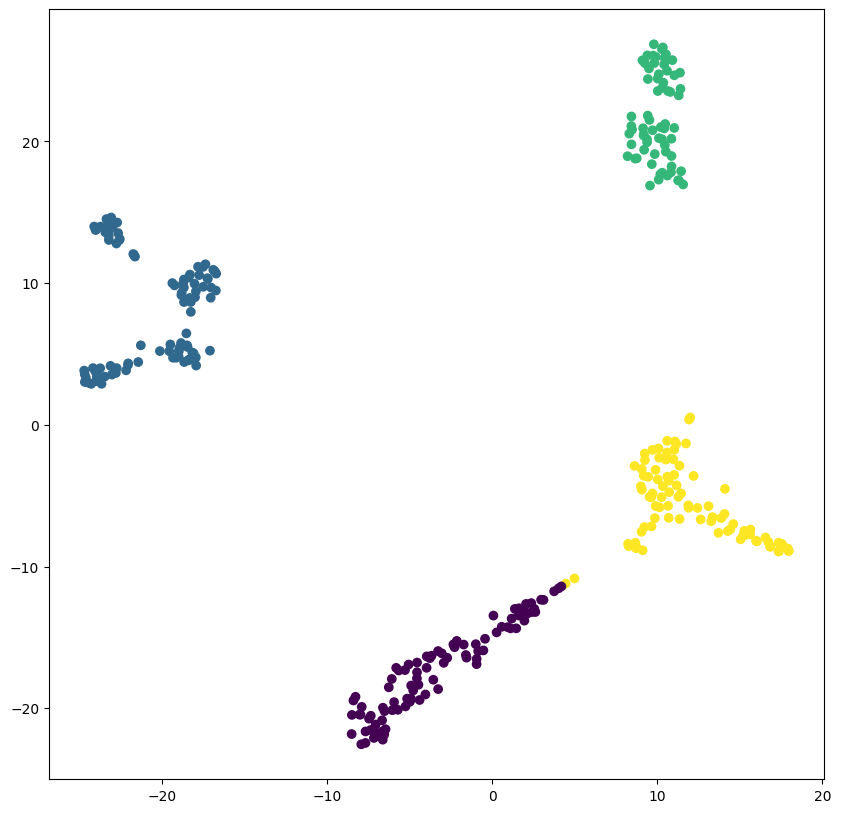

Current transformer: tf-idf


C:\Users\Monset\PycharmProjects\leaders_of_digitals_mo_2022\mo_env\lib\site-packages\sklearn\manifold\_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(


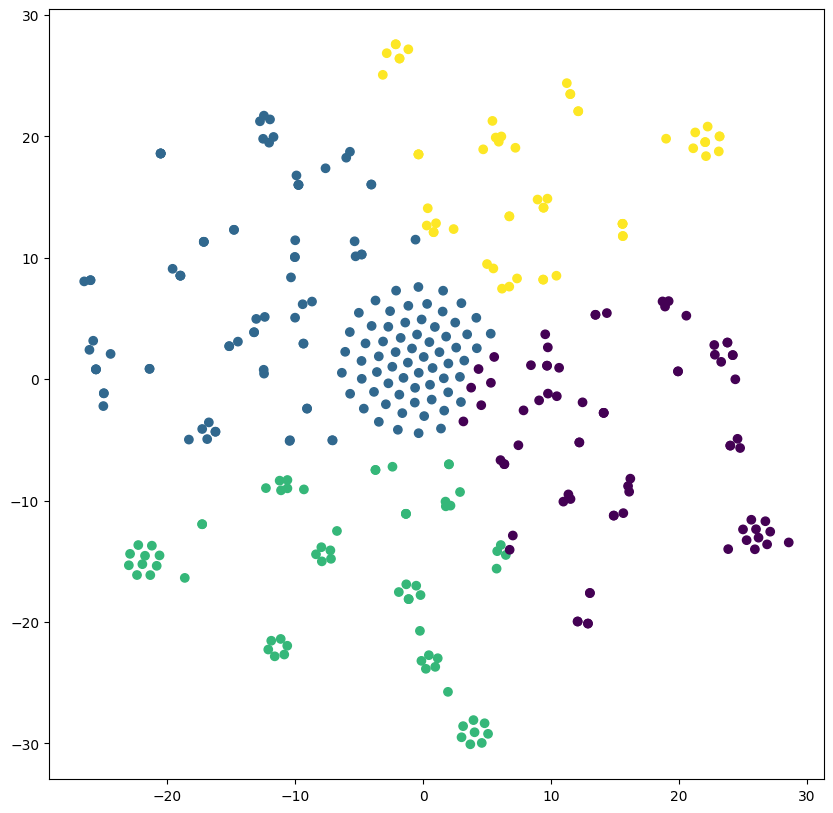

Current transformer: count


C:\Users\Monset\PycharmProjects\leaders_of_digitals_mo_2022\mo_env\lib\site-packages\sklearn\manifold\_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(


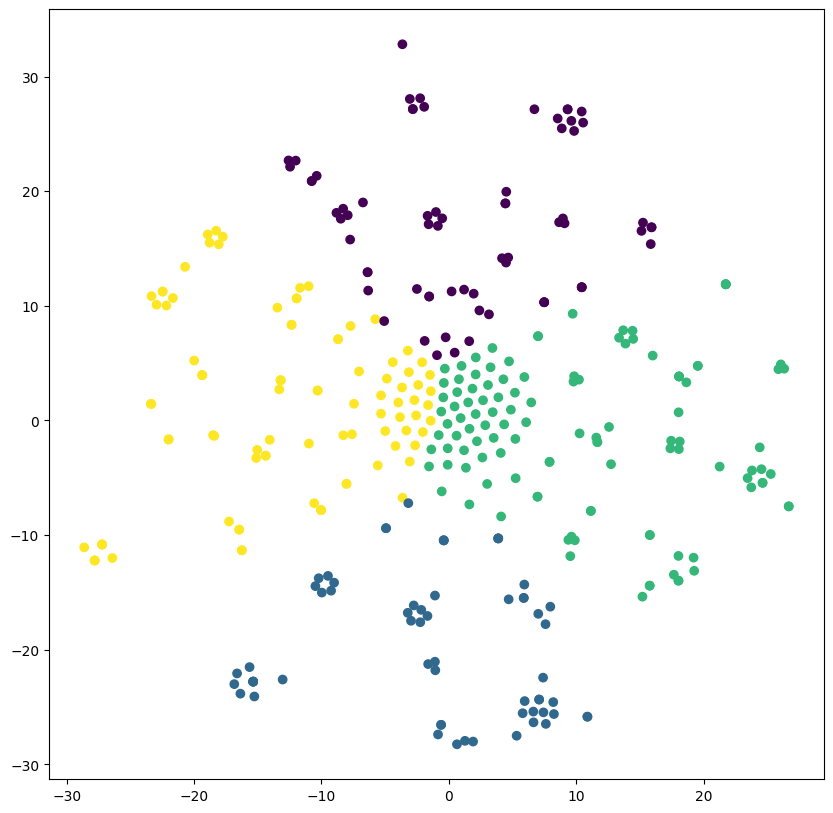

In [6]:
word2vec_params = dict(
    min_count=1,
    window=5,
    negative=5,
    )

for transformer in ['word2vec', 'tf-idf', 'count']:
    print('Current transformer: {}'.format(transformer))
    decision = pd.read_excel(os.path.join(DATA_PATH, 'decision.xlsx'))
    user_decision = pd.read_csv(os.path.join(DATA_PATH, 'user_decision.csv'))
    user_decision1 = user_decision.merge(decision, on = 'decision_id')
    decision = decision.loc[decision.decision_id.isin(user_decision1.decision_id)]
    clusters = get_text_clusters(decision.decision_name, n_clusters = 4, min_df = 5, transformer = transformer, user_decision = user_decision, **word2vec_params)

# decision.decision_name = clusters.label